<a href="https://colab.research.google.com/github/macontreras04/cpf/blob/main/2VolTrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Volatility Trading Strategies**
### *Author: Miguel Contreras*

## **Abstract**

In this project, various volatility trading strategies are discussed. The approaches include a classical strategy based on straddle delta-hedging, as well as more complex strategies using basic machine learning methods.
The core of this work relies on the concept of Volatility Risk Premium (VRP).
The main purpose is to apply financial theory combined with well-known techniques for algorithmic trading. The research conducted aims to reduce the probability of losses for each strategy. On the other hand, the optimization targets speacific performace metrics, such as the Sortino ratio.
Finally, a comparision of the strategies is presented, discussing their advantages and shortcomings.

**Key concepts:** Financial Theory, Volatility trading strategies, Volatility Risk Premium, Straddle, Delta-heding,
Algorithmic Trading, Machine Learning, Sortino Ratio.

## **1. Introduction**
The volatility risk premium (VRP) is the difference between the implied volatility (from instruments like VIX) and realized volatility. This premium compensates investors for taking on volatility risk. Understanding and predicting VRP is crucial for options pricing, risk management, and trading strategies.


## **2. Data Analysed**

The dataset analyzsed was obtained from Yahoo Finance 1st, The period studied was from August, 1st 2004 to  August 30 2024, meaning that approximately 5,000 financial business days were analyzed. The primary dataset focuses on the SPX Index and the VIX "Gauge Index". Since the VIX represents the expected volatility of the SPX over the next 20 business days, it is necessary  to apply a  one-month lag between these datasets. Further strategies requieres accounting for additional datesets as regressors. The explanatory variables include Brent's price, Euro Stoxx Index, Gold's price, and the Dollar Index.



## **3. Theoretical Background**

### **3.1 Volatility Risk Premium**

Trading volatility is a business usual practice for trading desks or treasuries of large financial institutions. The idea behid it is the Volatility Risk Premium. In financial markets it is possible to distinguish at least two types of voalitlity:

- **Realized Volatility (RV)**: The actual historical volatility of the underlying asset, calculated from past price data. A common technique to estimate RV is by applying moving averages.

- **Implied Volatility (IV)**: The market's forecast of a likely movement in a security's price. Implied volatility is derived from the prices of call/put options in equity or stocks markts, as wellas foreign exchange markets, for example.

The **Volatility Risk Premium (VRP)** is the spread between IV and RV. VRP tends to be positive, as IV typically overestimates future volatility. Nonethelles, dunring financial distress, this effect is reversed, with RV tending to be higher than IV.


### **3.2 VIX Futures and Contango/Backwardation**
- **VIX Futures**: Contracts based on the expected future value of the VIX index. These can trade at a premium or discount to the VIX spot price.
- **Contango**: A situation where VIX futures prices are higher than the spot price, indicating that implied volatility is expected to rise. Therefore the slope of the curve is positive.
- **Backwardation**: A situation where VIX futures prices are lower than the spot price, often occurring during market crises when realized volatility spikes above implied volatility. In contrast with Cotango, here the slop of the curve is negative.

### **3.3 Traditional Trading Strategies**
- **Rebalancing Straddles**: A strategy involving the frequent adjustment of straddle positions to capture volatility changes. Rebalancing is particularly relevant when the market is in contango. Indeed, it is a classical way to obtain a postitive PnL in the long-term.
- **Variance Swaps**: Instruments that allow investors to trade future realized volatility against current implied volatility.
- **ETFs of SPX**: Exchange-traded funds tracking the S&P 500 index, which can be used to hedge or speculate on broad market volatility.
- **Futures of VIX Curves as signals**: As mentioned above, the VIX curves can be used as a signal to forecast the VRP. If the curve is in contango, it is likely that IV will exceed RV, and vice versa. However, during times of financial distress, this behavior can be reversed.


## **4. The dataset**
As previously mentioned, the VIX is a forward-looking measure for 30 days. Therefore, a 30-day lag must be applied to align the volatility comparison with realized volatility. The financial data was sourced from Yahoo Finance, which provides consistent closing quotes comparable to those from well-known sources like Reuters and Bloomberg.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
# URL to the raw CSV file
url_dataset1 = 'https://raw.githubusercontent.com/macontreras04/cpf/main/dataset_strategy1.csv'

# Read the CSV file into a DataFrame
spx_data = pd.read_csv(url_dataset1)

### **4.1 The SPX Index**


The chart below displays the historical dataset of the SPX Index.

The SPX Index, often used as a benchmark for U.S. equities, represents the price evolution of 500 of the largest publicly traded companies in the U.S. market.


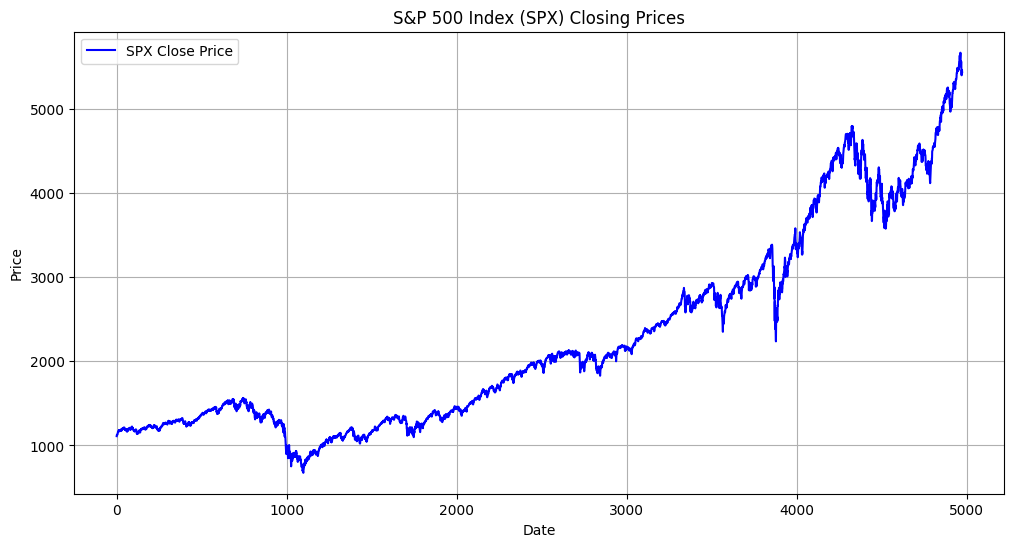

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(spx_data.index, spx_data['Close'], label='SPX Close Price', color='blue')

# Formatting the plot
plt.title('S&P 500 Index (SPX) Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### **4.2 Rolling Windows**

To model realized volatility, a simple 10-day rolling window has been chosen. It is well-known that the longer the window horizon, the smoother the moving average becomes. However, it's important to remain sensitive to market shifts, so a 10-day window is considered sufficient for this purpose.

The rolling window calculation for the moving average can be expressed as:

$$
MA_t = \frac{1}{n} \sum_{i=t-n+1}^{t} x_i
$$


In [ ]:
# Calculate realized volatility with different rolling window sizes
spx_data['realized_volatility_10d'] = spx_data['log_return'].rolling(window=10).std() * np.sqrt(252)  # 10-day rolling window

# Drop any rows with NaN values (due to rolling window or missing data)
spx_data.dropna(inplace=True)

### **4.3 Volatility Comparison**

In the following section a chart is presented that clearly demonstrates, on average, that IV is higher than RV. However, there remarkable  perios of distress where RV is higher than IV,  such as during the subprime crisis in 2008 and the COVID-19 pandemic in 2019.


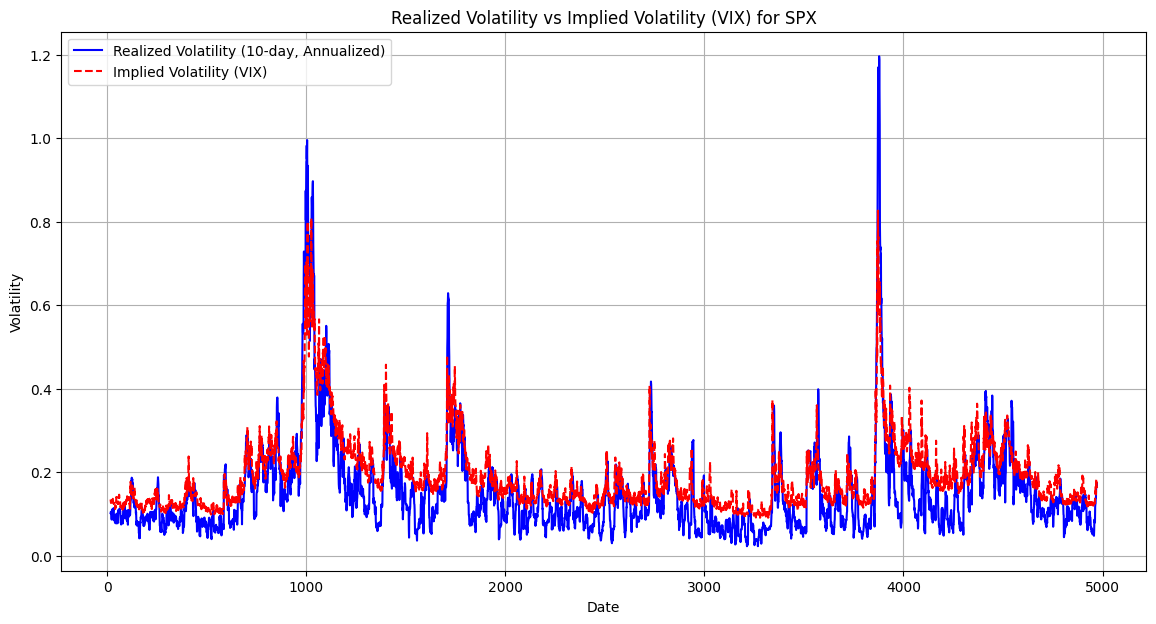

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(spx_data.index, spx_data['realized_volatility_10d'], label='Realized Volatility (10-day, Annualized)', color='blue')
plt.plot(spx_data.index, spx_data['implied_volatility'], label='Implied Volatility (VIX)', color='red', linestyle='dashed')

# Formatting the plot
plt.title('Realized Volatility vs Implied Volatility (VIX) for SPX')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

## **5. Strategy #1: A classic Straddle ATM strategy**

A straddle is a combination of a call and a put at the same strike. Typically, the strike is at-the-money (or near ATM), meaning that the underlying price and the strike are equal. Below a payoff diagram is presented as example.


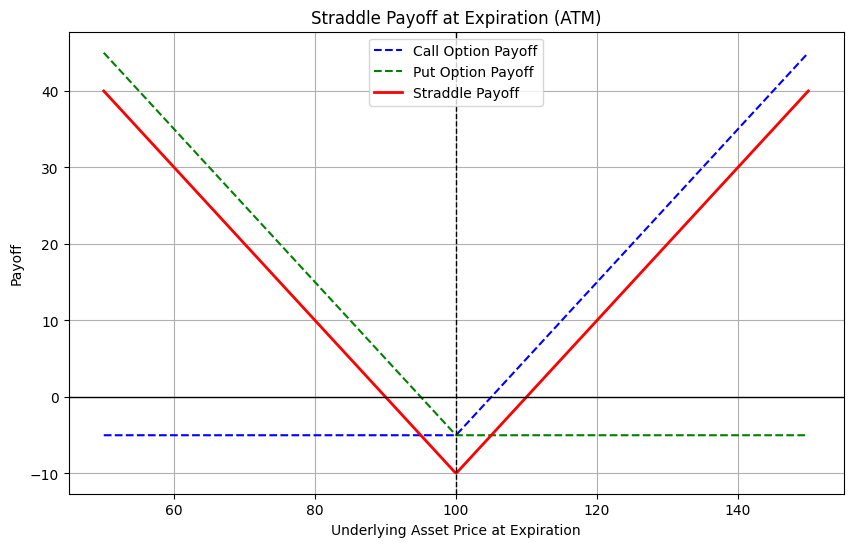

In [ ]:
# Parameters
strike_price = 100  # ATM strike price
premium_call = 5     # Premium paid for the call option
premium_put = 5      # Premium paid for the put option
S = np.linspace(50, 150, 500)  # Range of underlying asset prices

# Payoff for the call option
payoff_call = np.maximum(S - strike_price, 0) - premium_call

# Payoff for the put option
payoff_put = np.maximum(strike_price - S, 0) - premium_put

# Total payoff of the straddle strategy
payoff_straddle = payoff_call + payoff_put

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(S, payoff_call, '--', label="Call Option Payoff", color='blue')
plt.plot(S, payoff_put, '--', label="Put Option Payoff", color='green')
plt.plot(S, payoff_straddle, label="Straddle Payoff", color='red', linewidth=2)
plt.axhline(0, color='black',linewidth=1)
plt.axvline(strike_price, color='black',linestyle="--",linewidth=1)
plt.title('Straddle Payoff at Expiration (ATM)')
plt.xlabel('Underlying Asset Price at Expiration')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()

### **5.1 PnL Black-Scholes equation**

Using a straddle implies that the strategy is near delta zero. Applying a second-order Taylor expansion to Black-Scholes equation, it is possible decompose the Profit and Losses (PnL) attribution of an European Plain Vanilla Option price as following:

$$V(x + dx) - V(x) = PnL \approx dS.\Delta + (1/2).dS^2. \Gamma^2 + d \sigma.v$$

where

$\Delta, \Gamma, v$ are the **"Greeks"** of Black-Scholes formula

$dx$ is the differential of $S, S^2, \sigma$

$S$ is the equity price

$\sigma$ is the volatility  

It is worth mentioning that interest rate sensitivity ($\rho$) and $\Theta$ are not considered, as the straddle being proposed is short-term in nature.

Based on the PnL equation, when delta is zero, the strategy is mainly driven by vega, meaning the change in volatility closely approximates the PnL.

 If $\Delta = 0 \implies PnL  \approx d \sigma.v $

 Therefore, a delta zero strategy is proportional to **(IV-RV)**.

 The expected long-term behavior is that the strategy has a postive VRP:

 $$ 𝔼(IV-RV)>0$$

### **5.2 Straddle delta hedging strategy**

Here below is the straddle strategy implemented in Python. The idea behind it is, on one hand, to price a straddle using implied volatility. On the other hand, it is necessary to perform a Monte Carlo (MC) simulation of the SPX, using realized volatility, to obtain the straddle's payout. Additionally, delta-hedging is implemented every 5 business days, so a new ATM straddle is replaced in the strategy. This approach helps limit potential losses.

In [ ]:
''' Straddle Strategy Monte Carlo 1-week '''

# Black-Scholes formula for pricing options
def black_scholes(S, K, T, r, sigma, option_type="call"):
    if T <= 0:  # If time to maturity is zero or negative, option value is intrinsic value
        return max(0, S - K) if option_type == "call" else max(0, K - S)

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Delta for Black-Scholes
def delta(S, K, T, r, sigma, option_type="call"):
    if T <= 0:  # If time to maturity is zero, delta is 0 or 1 for intrinsic value
        return 1 if S > K else 0 if option_type == "call" else -1 if S < K else 0

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == "call":
        return norm.cdf(d1)
    elif option_type == "put":
        return -norm.cdf(-d1)

# Generate paths using Geometric Brownian Motion
def generate_paths(S0, T, r, sigma, steps, n_paths):
    dt = T / steps
    paths = np.zeros((steps + 1, n_paths))
    paths[0] = S0
    for t in range(1, steps + 1):
        Z = np.random.standard_normal(n_paths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Calculate PnL of the delta-hedged straddle strategy
def straddle_pnl_hedged(S0, K, r, sigma_realized, sigma_implied, T, steps, n_paths):
    dt = 1 / steps
    paths = generate_paths(S0, T, r, sigma_realized, steps, n_paths)

    pnl = np.zeros(n_paths)

    for i in range(n_paths):
        S_t = paths[:, i]
        T_t = T

        # Initial straddle price and delta
        call_delta = delta(S_t[0], K, T_t, r, sigma_implied, option_type="call")
        put_delta = delta(S_t[0], K, T_t, r, sigma_implied, option_type="put")
        delta_hedge = -(call_delta + put_delta)

        straddle_start = black_scholes(S_t[0], K, T_t, r, sigma_implied, option_type="call") + \
                          black_scholes(S_t[0], K, T_t, r, sigma_implied, option_type="put")

        daily_pnl = 0

        for t in range(1, steps + 1):
            T_t -= dt
            # Delta hedge adjustment
            call_delta = delta(S_t[t], K, T_t, r, sigma_implied, option_type="call")
            put_delta = delta(S_t[t], K, T_t, r, sigma_implied, option_type="put")
            new_delta_hedge = -(call_delta + put_delta)

            # PnL from rebalancing hedge
            hedge_pnl = delta_hedge * (S_t[t] - S_t[t - 1])
            daily_pnl += hedge_pnl

            delta_hedge = new_delta_hedge

        # Final straddle value
        straddle_end = black_scholes(S_t[-1], K, T_t, r, sigma_implied, option_type="call") + \
                        black_scholes(S_t[-1], K, T_t, r, sigma_implied, option_type="put")

        # Total PnL
        pnl[i] = (straddle_start - straddle_end) + daily_pnl

    return pnl

For the MC simulation, the followinng parameters are used. A fixed seed is applied for consistency. The risk-free rate, while not a critical factor in this case, is set at 5.33%. A total of 10,000 paths are simulated, which is sufficient to produce meaningful statistics. Finally, the PnL from the strategy is accumulated and displayed in a histogram.

In [ ]:
# Set random seed for reproducibility
np.random.seed(100)
# Parameters

# Use .iloc[0] to access the first element by position
S0 = spx_data['Close'].iloc[0]  # Initial stock price
K = spx_data['Close'].iloc[0]   # Strike price (at the money)
r = 0.0533  # Risk-free rate
sigma_realized = np.median(spx_data['realized_volatility_10d'])  # Realized volatility
sigma_implied = np.median(spx_data['implied_volatility'])  # Implied volatility
T = 5 / 252  # 5 trading days to expiry (weekly straddle)
n_paths = 10000  # Number of simulation paths
steps = 5  # Daily steps (5 days for weekly expiry)

# Calculate PnL for the delta-hedged straddle strategy
pnl_hedged = straddle_pnl_hedged(S0, K, r, sigma_realized, sigma_implied, T, steps, n_paths)

Even though the PnL distribution is skewed  toward positive outcomes, it is notable that it exhibits fat tails. The hypothesis is that, by applying a simple machine learning technique, the fat tails of the distribution can be reduced.

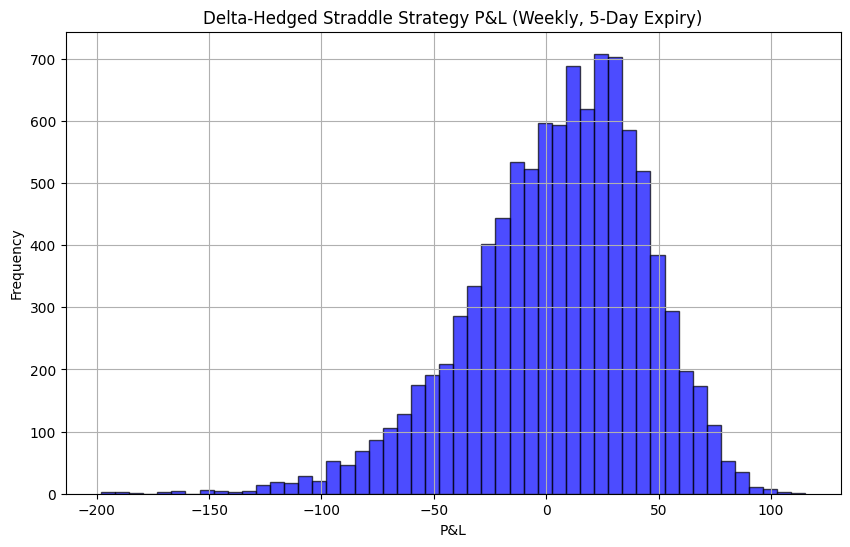

In [ ]:
# Plot the PnL histogram
plt.figure(figsize=(10, 6))
plt.hist(pnl_hedged, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Delta-Hedged Straddle Strategy P&L (Weekly, 5-Day Expiry)")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

This strategy  shows a long-run positive expected value of 4.9. However, it has a significant standard deviation. While the Sharpe Ratio is at the expected level, there is room for improvement. In addition, the strategy carries substantial risky, as in 4 of 10 cases, it is likely to incur significant losses.

In [ ]:
# Summary statistics
mean_pnl_hedged = np.mean(pnl_hedged)
std_pnl_hedged = np.std(pnl_hedged)
sharpe_ratio = mean_pnl_hedged / std_pnl_hedged * np.sqrt(252)  # Annualized Sharpe ratio

# Probability of Losses
num_losses = np.sum(pnl_hedged < 0)  # Count how many times the strategy incurs a loss
probability_of_loss = num_losses / n_paths * 100  # Convert to percentage

# Print statistics
print(f"Mean P&L: {mean_pnl_hedged:.2f}")
print(f"Standard Deviation of P&L: {std_pnl_hedged:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Number of Losses: {num_losses} out of {n_paths} simulations")
print(f"Probability of Loss: {probability_of_loss:.2f}%")

Mean P&L: 4.90
Standard Deviation of P&L: 39.26
Sharpe Ratio: 1.98
Number of Losses: 4058 out of 10000 simulations
Probability of Loss: 40.58%


## **6. Strategy #2: A Straddle strategy with machine learning**


The following section builds on the previous strategy involving straddles. The key difference lies in incorporating market information to optimize the Sharpe Ratio and reduce potential losses. This strategy was designed as a linear model, using market indices that have a strong correlation with the SPX. The linear regression incorporates Brent's price, Gold's price, the Euro Stoxx Index, and the Dollar Index.

As Warren Buffett once said, "Risk comes from not knowing what you're doing." By integrating these market indices, we aim to better understand and manage risk, ultimately improving the strategy's performance.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### **6.1 Updating the dataset with the market**


It is worth mentioning that in the linear model, the dependent variable is the volatility spread, while the market information is represented in the form of a matrix.

$$ ℳ(Brent, Gold, Euro Stoxx Index, Dollar Index)$$

In [ ]:
# Adjusted threshold percentage for implied vs realized volatility spread
vol_spread_threshold = 0.01  # 1% higher implied volatility than realized (smaller threshold)

# URL to the raw CSV file
url_dataset2 = 'https://raw.githubusercontent.com/macontreras04/cpf/main/dataset_strategy2.csv'

# Read the CSV file into a DataFrame
spx_data = pd.read_csv(url_dataset2)

In this part of the script, the dataset is split into training and test sets before the linear regression is performed.

In [ ]:
# Prepare data for multiple linear regression
X = spx_data[['Close_brent', 'Close_euro_stoxx', 'Close_gold', 'Close_dxy']]  # Independent variables
y = spx_data['vol_spread']  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a multiple linear regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict the volatility spread on the test data
y_pred = reg.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Predict the volatility spread for the entire dataset
spx_data['predicted_vol_spread'] = reg.predict(X)

Mean Squared Error: 0.0005


The next part of the script involves integrating the linear model into the previous function for strategy #1.

In [ ]:
# Black-Scholes formula for pricing options
def black_scholes(S, K, T, r, sigma, option_type="call"):
    if T <= 0:
        return max(0, S - K) if option_type == "call" else max(0, K - S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Delta for Call option in Black-Scholes
def delta_call(S, K, T, r, sigma):
    if T <= 0:
        return 1 if S > K else 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Delta for Put option in Black-Scholes
def delta_put(S, K, T, r, sigma):
    if T <= 0:
        return -1 if S < K else 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return -norm.cdf(-d1)

# Monte Carlo simulation paths
def generate_paths(S0, T, r, sigma, steps, n_paths):
    dt = T / steps
    paths = np.zeros((steps + 1, n_paths))
    paths[0] = S0
    for t in range(1, steps + 1):
        Z = np.random.standard_normal(n_paths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Straddle Strategy based on predicted volatility spread
def straddle_with_predicted_vol_spread(S0, K, r, sigma_realized, sigma_implied, T, steps, n_paths, predicted_vol_spread, vol_spread_threshold):
    dt = T / steps
    paths = generate_paths(S0, T, r, sigma_realized, steps, n_paths)
    pnl = np.zeros(n_paths)

    # Loop through each path and adjust position size based on the predicted volatility spread
    for i in range(n_paths):
        S_t = paths[:, i]
        T_t = T
        vol_spread = predicted_vol_spread.sample().values[0]  # Randomly sample from predicted_vol_spread

        # Adjust position size based on the magnitude of the predicted volatility spread
        if vol_spread > vol_spread_threshold:
            position_size = vol_spread / sigma_realized  # Larger spread -> Larger position size
            position_size = max(position_size, 0.1)  # Ensure a minimum position size

            straddle_start = (black_scholes(S_t[0], K, T_t, r, sigma_implied, option_type="call") +
                              black_scholes(S_t[0], K, T_t, r, sigma_implied, option_type="put")) * position_size

            call_delta = delta_call(S_t[0], K, T_t, r, sigma_implied)
            put_delta = delta_put(S_t[0], K, T_t, r, sigma_implied)
            delta_hedge = -(call_delta + put_delta) * position_size
            daily_pnl = 0

            for t in range(1, steps + 1):
                T_t -= dt
                call_delta = delta_call(S_t[t], K, T_t, r, sigma_implied)
                put_delta = delta_put(S_t[t], K, T_t, r, sigma_implied)
                new_delta_hedge = -(call_delta + put_delta) * position_size
                hedge_pnl = delta_hedge * (S_t[t] - S_t[t - 1])
                daily_pnl += hedge_pnl
                delta_hedge = new_delta_hedge

            straddle_end = (black_scholes(S_t[-1], K, T_t, r, sigma_implied, option_type="call") +
                            black_scholes(S_t[-1], K, T_t, r, sigma_implied, option_type="put")) * position_size
            pnl[i] = (straddle_start - straddle_end) + daily_pnl
        else:
            pnl[i] = 0  # No trade if threshold not met

    return pnl


Before implementing the simulation, the MC parameters are presented below.

In [ ]:
# Parameters for the straddle strategy
# Set random seed for reproducibility
np.random.seed(100)

n_paths = 10000
steps = 5  # Simulating 5 days (1 week)
S0 = spx_data['Close'].iloc[0]
K = spx_data['Close'].iloc[0]  # At-the-money
r = 0.0533  # Risk-free rate
sigma_realized = np.median(spx_data['realized_volatility_10d'])  # Realized volatility
sigma_implied = np.median(spx_data['implied_volatility'])  # Implied volatility
T = 5 / 252  # 5 trading days to expiry (weekly straddle)

# Implement the straddle strategy using the predicted volatility spread
total_pnl = straddle_with_predicted_vol_spread(S0, K, r, sigma_realized, sigma_implied, T, steps, n_paths, spx_data['predicted_vol_spread'], vol_spread_threshold)

The final steps involve calculating the statistics from the simulations, such as the Sharpe Ratio and the probability of losses.

In [ ]:
# Sharpe ratio and probability of loss calculation
mean_pnl = np.mean(total_pnl)
std_pnl = np.std(total_pnl)
sharpe_ratio = mean_pnl / std_pnl * np.sqrt(252) if std_pnl > 0 else 0
num_losses = np.sum(total_pnl < 0)
probability_of_loss = num_losses / n_paths * 100

The statistics show that the Sharpe Ratio increased to 2.33, and the probability of losses decreased to 35%. Although the mean PnL was slightly reduced, the standard deviation also decreased, indicating improved consistency in the strategy's performance.

In [ ]:
# Print statistics
print(f"Mean P&L: {mean_pnl:.2f}")
print(f"Standard Deviation of P&L: {std_pnl:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Number of Losses: {num_losses} out of {n_paths} simulations")
print(f"Probability of Loss: {probability_of_loss:.2f}%")

Mean P&L: 3.72
Standard Deviation of P&L: 25.29
Sharpe Ratio: 2.33
Number of Losses: 3555 out of 10000 simulations
Probability of Loss: 35.55%


We can observe that the fat tails of the PnL distribution have been reduced.

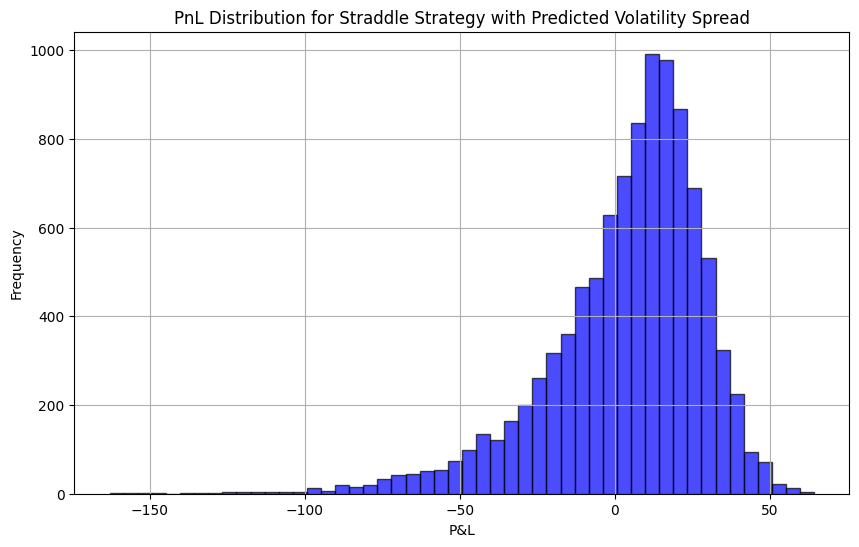

In [ ]:
# Plot the PnL histogram
plt.figure(figsize=(10, 6))
plt.hist(total_pnl, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("PnL Distribution for Straddle Strategy with Predicted Volatility Spread")
plt.xlabel("P&L")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## **7. Conclusions**

This work illustrates a common volatility strategy based on short-term ATM straddles, utilizing delta-hedging. Additionally, the strategy was enhanced by applying a simple linear model with a few regressors. This suggests that more advanced machine learning techniques, such as Random Forest, could also be implemented with additional explanatory variables. The VRP is not limited to the SPX or equity markets but is also inherent in other financial markets, such as foreign exchange. Moreover, using machine learning algorithms to optimize the Sharpe Ratio and reduce the probability of losses is a growing area of research in the euro FX markets. Naturally, other techniques, such as Deep Learning or Reinforcement Learning, could be integrated as well.

In conclusion, this project contributes to the expanding body of knowledge on applying ML models to financial markets, particularly in the field of volatility trading. The integration of a simple linear regression model with traditional volatility trading strategies presents a promising avenue for both future research and practical application. By continually refining these models and exploring new data sources, traders and quants can more effectively navigate the complexities of financial markets, leading to more consistent and profitable outcomes.

###**Bibliography**

1. Hilpisch, Y., 2021. Financial Theory with Python: A Gentle Introduction. Sebastopol, CA: O'Reilly Media, Inc.

2. Hilpisch, Y., 2019. Python for Finance: Mastering Data-Driven Finance. 2nd ed. Sebastopol, CA: O'Reilly Media.

3. Hilpisch, Y., 2015. Derivatives Analytics with Python: Data Analysis, Models, Simulation, Calibration and Hedging. Hoboken, NJ: Wiley.

4. Hilpisch, Y., 2020. Python for Algorithmic Trading: From Idea to Cloud Deployment. Sebastopol, CA: O'Reilly Media.

5. Sinclair, E., 2013. Volatility Trading. 2nd ed. Hoboken, NJ: Wiley.

6. Sinclair, E., 2020. Positional Option Trading: An Advanced Guide. Hoboken, NJ: Wiley & Sons, Inc.





